In [ ]:
import numpy as np
import pandas as pd
import subprocess
import os
import shutil
import warnings
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
warnings.filterwarnings('ignore')



Make VSF plots

In [ ]:
def plot_data(df, cond, cond_name, y_ax,suf):
    df = df[cond]
    df.columns = cond_name
    ax = df.plot.line()
    ax.set_xlabel("Number of Voxels")
    ax.set_ylabel(y_ax)
    plt.title(f'{lr}{rois[rr]}')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{sub_dir}/results/{lr}{rois[rr]}_{suf}.png',bbox_inches='tight')
    #plt.close()

Calculate distance from to each voxel to peak voxel

In [ ]:
def calc_distance(loc_df):
    peak_vox = loc_df.iloc[0,0:3]

    all_coords = loc_df.iloc[:,0:3]

    dist = all_coords[['x', 'y', 'z']].sub(np.array(peak_vox)).pow(2).sum(1).pow(0.5)
    return dist


Function to extract functional localizer data from each ROI and parameter estimate from each mask

In [ ]:
def extract_data(sub_dir, results_dir, lr, rr):
    #check if ROI exists
    for sf_loc in suf: #loop across run type for the masks
        roi_nifti = f'{sub_dir}/rois/{lr}{rois[rr]}{sf_loc}.nii.gz'
        if os.path.exists(roi_nifti):

            #Extract functional z-stat data from the localizer
            #if sf_loc != '_all':
            loc_suf = f'{sf_loc}_smooth'
            #else:
            #   loc_suf = sf_loc

            cope_nifti = f"{sub_dir}/fsl/{exp}/HighLevel{loc_suf}.gfeat/cope{loc_cope[rr]}.feat/stats/zstat1.nii.gz"
            out = f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer'
            #extract_data(cope_nifti, roi_nifti, f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer')

            bash_cmd  = f'fslmeants -i {cope_nifti} -m {roi_nifti} -o {out}.txt --showall --transpose'
            subprocess.run(bash_cmd.split(),check=True)

            for sf_exp in suf: #loop across the run types for the copes
                exp_suf = f'{sf_exp}_unsmoothed'
                if sf_exp != "_all": #we don't test data for all
                    for ec in range(0,len(exp_cope)):
                        cope_nifti = f"{sub_dir}/fsl/{exp}/HighLevel{exp_suf}.gfeat/cope{exp_cope[ec]}.feat/stats/pe1.nii.gz"
                        out = f'{results_dir}/{lr}{rois[rr]}{sf_loc}{sf_exp}_{cond[ec]}'
                        #extract_data(roi_nifti, cope_nifti, f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer.nii.gz')

                        bash_cmd  = f'fslmeants -i {cope_nifti} -m {roi_nifti} -o {out}.txt --showall --transpose'
                        #print(bash_cmd)
                        subprocess.run(bash_cmd.split(),check=True)


Function to load localizer and test data, append, average together, and plot

In [26]:
def calc_selectivity(lr, rr, bin_size):
    #define and read localzier files
    odd_file = f'{results_dir}/{lr}{rois[rr]}_odd_localizer.txt'
    even_file = f'{results_dir}/{lr}{rois[rr]}_even_localizer.txt'
        
    odd_df = pd.read_csv(odd_file, sep="  ", header=None, names = ["x", "y", "z", "loc"])
    even_df = pd.read_csv(even_file, sep="  ", header=None, names = ["x", "y", "z", "loc"])


    for cc in cond:
        #define  odd and even exp file
        #note that it should be pulled from the opposite test runs (from even ROI pull odd data)
        #all naming convetions are relative to the ROI that data are being pulled
        #odd_exp_file is even data pulled from *odd* run ROI
        odd_exp_file = f'{results_dir}/{lr}{rois[rr]}_odd_even_{cc}.txt'
        even_exp_file = f'{results_dir}/{lr}{rois[rr]}_even_odd_{cc}.txt'

        #load each file
        odd_exp = pd.read_csv(odd_exp_file, sep="  ", header=None, names = ["x", "y", "z", cc])
        even_exp = pd.read_csv(even_exp_file, sep="  ", header=None, names = ["x", "y", "z", cc])                        

        #Append it to the localizer data
        odd_df = odd_df.join(odd_exp[cc])
        even_df = even_df.join(even_exp[cc])

    #sort file by localizer functional value (high to low)
    #Reset the index on both
    odd_df = odd_df.sort_values(by =['loc'], ascending=False)
    even_df = even_df.sort_values(by =['loc'], ascending=False)
    odd_df= odd_df.reset_index(drop=True)
    even_df= even_df.reset_index(drop=True)
    
    #If you want to srot ROI voxels contiguously by distance from peak
    #Reset the index on both
    if roi_type == 'dist':
        odd_df['dist'] = calc_distance(odd_df)
        even_df['dist'] = calc_distance(even_df)
        
        odd_df = odd_df.sort_values(by =['dist', 'loc'], ascending=[True, False])
        even_df = even_df.sort_values(by =['dist', 'loc'], ascending=[True, False])
        odd_df= odd_df.reset_index(drop=True)
        even_df= even_df.reset_index(drop=True)
        
    #subsample dfs using a rolling average
    odd_df = odd_df.rolling(bin_size, win_type='triang').mean()
    odd_df = odd_df.dropna()

    even_df = even_df.rolling(bin_size, win_type='triang').mean()
    even_df = even_df.dropna()

    
    
    #reduce size to smaller matrix
    if len(odd_df) <= len(even_df):
        even_df = even_df.head(len(odd_df))
    else:
        odd_df = odd_df.head(len(even_df))

    odd_test = odd_df
    even_test = even_df
    #odd_df= odd_df.reset_index(drop=True)
    #even_df= even_df.reset_index(drop=True)


    #average the dataframes together
    df = pd.concat([odd_df, even_df]).groupby(level=0).mean()

    return df, odd_test, even_test


Calculate within- between- Haxby-style MVPA

In [ ]:
def calc_mvpa(lr, rr, bin_size):
    #define and read localzier files
    loc_file = f'{results_dir}/{lr}{rois[rr]}_all_localizer.txt'

    loc_df = pd.read_csv(loc_file, sep="  ", header=None, names = ["x", "y", "z", "loc"])

    for cc in mvpa_cond:
        #define  odd and even exp file
        #note that it should be pulled from the opposite test runs (from even ROI pull odd data)
        #all naming convetions are relative to the ROI that data are being pulled
        #odd_exp_file is even data pulled from *odd* run ROI
        odd_exp_file = f'{results_dir}/{lr}{rois[rr]}_all_odd_{cc}.txt'
        even_exp_file = f'{results_dir}/{lr}{rois[rr]}_all_even_{cc}.txt'

        #load each file and append localizer functional value
        odd_exp = pd.read_csv(odd_exp_file, sep="  ", header=None, names = ["x", "y", "z", f'{cc}_odd'])
        even_exp = pd.read_csv(even_exp_file, sep="  ", header=None, names = ["x", "y", "z", f'{cc}_even'])

        loc_df = loc_df.join([odd_exp[cc + "_odd"],even_exp[cc+"_even"]])
        #sort  by localizer value
    
    loc_df = loc_df.sort_values(by =['loc'], ascending=False)
    loc_df= loc_df.reset_index(drop=True)
    
    if roi_type == 'dist':
        loc_df['dist'] = calc_distance(loc_df)
        
        loc_df = loc_df.sort_values(by =['dist', 'loc'], ascending=[True, False])
        loc_df= loc_df.reset_index(drop=True)
        

    #demean columns by condition
    #demeaning is important here, because you are correlating across voxel and so you might have 
    #a shadow correlation because that voxel is arbitrarily high
    row_mean=loc_df[[f'{mvpa_cond[0]}_odd', f'{mvpa_cond[0]}_even', f'{mvpa_cond[1]}_odd',f'{mvpa_cond[1]}_even']].mean(axis=1)
    
    #row_mean=loc_df.iloc[:,4:loc_df.shape[1]].mean(axis=1)
    #loc_df.iloc[:,4:loc_df.shape[1]] =loc_df.iloc[:,4:loc_df.shape[1]].sub(row_mean,axis=0)
    exp_df =loc_df[[f'{mvpa_cond[0]}_odd', f'{mvpa_cond[0]}_even', f'{mvpa_cond[1]}_odd',f'{mvpa_cond[1]}_even']].sub(row_mean,axis=0)

    #Start within-between analysis
    n = 1
    df = pd.DataFrame()
    between_temp = pd.DataFrame() 
    for c1 in mvpa_cond:
        for c2 in mvpa_cond:

            temp_x = exp_df[f'{c1}_odd']
            temp_y = exp_df[f'{c2}_even']
            temp = temp_x.rolling(bin_size).corr(temp_y)
            temp = temp.dropna()
            temp= temp.reset_index(drop=True)

            if c1 == c2:
                temp = pd.DataFrame(temp)
                temp.columns= [f'{c1}']
                if df.empty:
                    df = temp
                else:
                    df = df.join(temp)
            else:
                if between_temp.empty:
                    between_temp =temp
                else:
                    between_temp =between_temp + temp
                    n = n + 1

    between = pd.DataFrame(between_temp/n)
    between.columns = ['between']
    df = df.join(between)


    #df = df.sub(between,axis=0)
    return df #,loc_df,exp_df, row_mean


Start analysis loop

Parmaters for the current analysis

In [ ]:
exp ='spaceloc'
subj_list=["docnet1001", "docnet1002"] #subs to analyze
suf = ["_odd", "_even", "_all"] #runs to pull ROIs from
rois=["V3ab", "PPC", "APC", "V4", "LO", "PFS"] #Rois
loc_cope=[1, 1, 1, 2, 2, 2] #copes for localizer runs; corresponding numerically to each roi
exp_cope=[8, 9, 10, 11] #experimental copes to test in each ROI

bin_size=100
max_bins = 1000
cond=["SA", "FT", "SS", "SF"]
cond_name =  ["Space", "Feature", "Scrambled_Space", "Scrambled_Feature"]
mvpa_cond = ["SA", "FT"]
mvpa_cond_name = ["Space", "Feature", "Between"]

bool_extract_data = False
bool_calc_act = True
bool_calc_mvpa = True
roi_type = 'dist'

data_dir = "/lab_data/behrmannlab/vlad/docnet"

In [ ]:
for ss in subj_list:
    sub_dir = f"{data_dir}/sub-{ss}/ses-01/derivatives"
    results_dir = f'{sub_dir}/beta/selectivity'
       
    #if os.path.exists(results_dir):
    #    shutil.rmtree(results_dir)
    
    os.makedirs(results_dir,exist_ok = True) 
    

    for rr in range(0,len(rois)): #loop across rois
        for lr in ['l','r']: #loop across left and right hemispheres
            odd_roi = f'{sub_dir}/rois/{lr}{rois[rr]}_odd.nii.gz'
            even_roi = f'{sub_dir}/rois/{lr}{rois[rr]}_even.nii.gz'
            
            #check if odd and even roi exist
            if os.path.exists(odd_roi) and os.path.exists(even_roi):            
                print(ss, lr,rois[rr],bin_size)
                
                if bool_extract_data:
                    extract_data(sub_dir, results_dir, lr, rr)
                # Sort and combine split runs
                
                if bool_calc_act:
                    df = calc_selectivity(lr, rr, bin_size)
                    if len(df) > max_bins: 
                        df = df.head(max_bins)
                    plot_data(df,cond,cond_name,'Parameter Estimate',f'selectivity_{roi_type}_{max_bins}')

                if bool_calc_mvpa:
                    df = calc_mvpa(lr, rr, bin_size)
                    if len(df) > max_bins: 
                        df = df.head(max_bins)

                    plot_data(df,mvpa_cond + ['between'],mvpa_cond_name,'Correlation',f'mvpa_{roi_type}_{max_bins}')


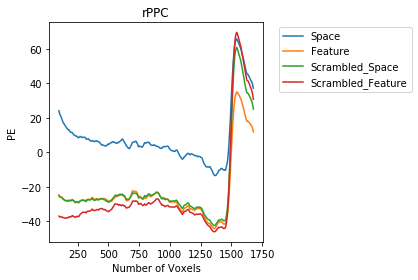

In [27]:
ss="docnet1002"
sub_dir = f"{data_dir}/sub-{ss}/ses-01/derivatives"
results_dir = f'{sub_dir}/beta/selectivity'
roi_type = 'dist'
lr="r"
rr=1
#df, odd, exp_df, row_mean = calc_mvpa(lr, rr, bin_size)
df, odd,even = calc_selectivity(lr, rr, bin_size)
plot_data(df,cond,cond_name,'PE','test')


In [ ]:
row_mean=loc_df.iloc[:,4:loc_df.shape[1]].mean(axis=1)

In [ ]:
test=loc_df[["SA_odd", "SA_even", "FT_odd", "FT_even"]].mean(axis=1)